# Demo SingleRun
This notebook shows a single run consisting of the following four phases:
* sail empty
* loading
* sail full
* unloading

In [1]:
import datetime, time
import simpy

import shapely.geometry


import pandas as pd
import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot



In [10]:
nr_vessels = 5

simulation_start = 0
my_env = simpy.Environment(initial_time=simulation_start)
registry = {}
keep_resources = {}

Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
    ),
    {},
)

TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,
        core.Log,
        core.ContainerDependentMovable,
        core.Processor,
        core.HasResource,
        core.LoadingFunction,
        core.UnloadingFunction,
    ),
    {},
)
location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)
location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)


from_site = Site(
    env=my_env,
    name="Winlocatie",
    geometry=location_from_site,
    capacity=995,
    level=995,
)


to_site = Site(
    env=my_env,
    name="Dumplocatie",
    geometry=location_to_site,
    capacity=995,
    level=0,
)
vessels = []
processes = []
for i in range(1, nr_vessels + 1):

    hopper = TransportProcessingResource(
        env=my_env,
        name=f"Hopper {i}",
        geometry=location_from_site,
        loading_rate=0.00001,
        unloading_rate=0.00001,
        capacity=10,
        compute_v=lambda x: 10,
    )
    vessels.append(hopper)
    requested_resources={}
    single_run = [
        model.MoveActivity(
            env=my_env,
            name=f"sailing empty {i}",
            registry=registry,
            mover=hopper,
            destination=from_site,
            requested_resources=requested_resources,
        ),
        model.ShiftAmountActivity(
            env=my_env,
            name=f"Transfer MP {i}",
            registry=registry,
            processor=hopper,
            origin=from_site,
            destination=hopper,
            amount=10,
            duration=1000,
            requested_resources=requested_resources,
        ),
        model.MoveActivity(
            env=my_env,
            name=f"sailing filler {i}",
            registry=registry,
            mover=hopper,
            destination=to_site,
            requested_resources=requested_resources,
        ),
        model.ShiftAmountActivity(
            env=my_env,
            name=f"Transfer TP {i}",
            registry=registry,
            processor=hopper,
            origin=hopper,
            destination=to_site,
            amount=10,
            duration=1000,
            requested_resources=requested_resources,
        ),
        model.BasicActivity(
            env=my_env,
            name=f"Basic activity {i}",
            registry=registry,
            duration=0,
            additional_logs=[hopper],
            requested_resources=requested_resources,
        ),
    ]


    activity = model.SequentialActivity(
        env=my_env,
        name=f"Single run process {i}",
        registry=registry,
        sub_processes=single_run,
    )


    while_activity = model.WhileActivity(
        env=my_env,
        name=f"while {i}",
        registry=registry,
        sub_processes=[activity],
        condition_event=[{"type": "container", "concept": to_site, "state": "full"}],
    )
    processes.append(while_activity)

model.register_processes(processes)
my_env.run()

return {
    "env":my_env,
    "vessels":vessels,
    "processes":processes,
    "from_site":from_site,
    "to_site":to_site,
}

AssertionError: 

None

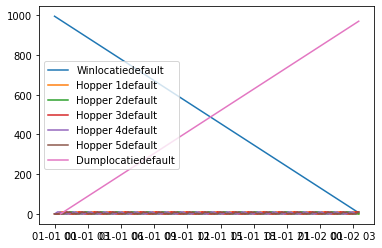

In [11]:
acts = []
for p in processes:
    acts.extend(p.sub_processes[0].sub_processes)
    
display(plot.vessel_planning(acts))
# display(plot.vessel_planning([*vessels, from_site, to_site]))
fig = plot.get_step_chart([from_site, *vessels, to_site])